In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import pathlib
import numpy as np

from pymdp.agent import Agent
from pymdp import utils, maths

In [2]:
from pymdp.envs.grid_world_2 import GridWorldCueEnv

In [3]:
grid_dims = [5, 7] # dimensions of the grid (number of rows, number of columns)
num_grid_points = np.prod(grid_dims) # total number of grid locations (rows X columns)

# create a look-up table `loc_list` that maps linear indices to tuples of (y, x) coordinates 
grid = np.arange(num_grid_points).reshape(grid_dims)
it = np.nditer(grid, flags=["multi_index"])

loc_list = []
while not it.finished:
    loc_list.append(it.multi_index)
    it.iternext()

# (y, x) coordinate of the first cue's location, and then a list of the (y, x) coordinates of the possible locations of the second cue, and their labels (`L1`, `L2`, ...)
cue1_location = (2, 0)

cue2_loc_names = ['L1', 'L2', 'L3', 'L4']
cue2_locations = [(0, 2), (1, 3), (3, 3), (4, 2)]

# names of the reward conditions and their locations
reward_conditions = ["TOP", "BOTTOM"]
reward_locations = [(1, 5), (3, 5)]


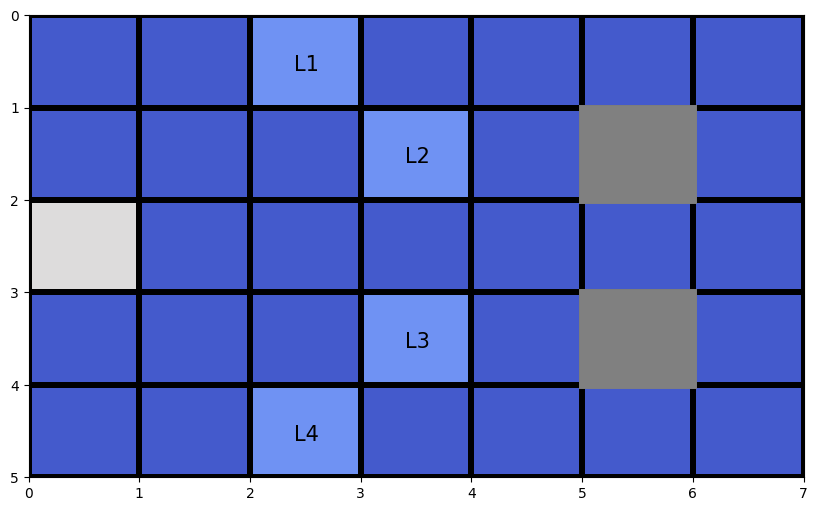

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

fig, ax = plt.subplots(figsize=(10, 6)) 

# create the grid visualization
X, Y = np.meshgrid(np.arange(grid_dims[1]+1), np.arange(grid_dims[0]+1))
h = ax.pcolormesh(X, Y, np.ones(grid_dims), edgecolors='k', vmin = 0, vmax = 30, linewidth=3, cmap = 'coolwarm')
ax.invert_yaxis()

# Put gray boxes around the possible reward locations
reward_top = ax.add_patch(patches.Rectangle((reward_locations[0][1],reward_locations[0][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor=[0.5, 0.5, 0.5]))
reward_bottom = ax.add_patch(patches.Rectangle((reward_locations[1][1],reward_locations[1][0]),1.0,1.0,linewidth=5,edgecolor=[0.5, 0.5, 0.5],facecolor=[0.5, 0.5, 0.5]))

text_offsets = [0.4, 0.6]

cue_grid = np.ones(grid_dims)
cue_grid[cue1_location[0],cue1_location[1]] = 15.0
for ii, loc_ii in enumerate(cue2_locations):
  row_coord, column_coord = loc_ii
  cue_grid[row_coord, column_coord] = 5.0
  ax.text(column_coord+text_offsets[0], row_coord+text_offsets[1], cue2_loc_names[ii], fontsize = 15, color='k')
h.set_array(cue_grid.ravel())



In [5]:
# list of dimensionalities of the hidden states -- useful for creating generative model later on
num_states = [num_grid_points, len(cue2_locations), len(reward_conditions)]

# Names of the cue1 observation levels, the cue2 observation levels, and the reward observation levels
cue1_names = ['Null'] + cue2_loc_names # signals for the possible Cue 2 locations, that only are seen when agent is visiting Cue 1
cue2_names = ['Null', 'reward_on_top', 'reward_on_bottom']
reward_names = ['Null', 'Cheese', 'Shock']

num_obs = [num_grid_points, len(cue1_names), len(cue2_names), len(reward_names)]

In [6]:
A_m_shapes = [ [o_dim] + num_states for o_dim in num_obs] # list of shapes of modality-specific A[m] arrays
A = utils.obj_array_zeros(A_m_shapes) # initialize A array to an object array of all-zero subarrays

In [7]:
# make the location observation only depend on the location state (proprioceptive observation modality)
A[0] = np.tile(np.expand_dims(np.eye(num_grid_points), (-2, -1)), (1, 1, num_states[1], num_states[2]))

In [8]:
# make the cue1 observation depend on the location (being at cue1_location) and the true location of cue2
A[1][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

# Make the Cue 1 signal depend on 1) being at the Cue 1 location and 2) the location of Cue 2
for i, cue_loc2_i in enumerate(cue2_locations):
    A[1][0,loc_list.index(cue1_location),i,:] = 0.0
    A[1][i+1,loc_list.index(cue1_location),i,:] = 1.0

In [9]:
# make the cue2 observation depend on the location (being at the correct cue2_location) and the reward condition
A[2][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

for i, cue_loc2_i in enumerate(cue2_locations):

    # if the cue2-location is the one you're currently at, then you get a signal about where the reward is
    A[2][0,loc_list.index(cue_loc2_i),i,:] = 0.0 
    A[2][1,loc_list.index(cue_loc2_i),i,0] = 1.0
    A[2][2,loc_list.index(cue_loc2_i),i,1] = 1.0

In [10]:
# make the reward observation depend on the location (being at reward location) and the reward condition
A[3][0,:,:,:] = 1.0 # default makes Null the most likely observation everywhere

rew_top_idx = loc_list.index(reward_locations[0]) # linear index of the location of the "TOP" reward location
rew_bott_idx = loc_list.index(reward_locations[1]) # linear index of the location of the "BOTTOM" reward location

# fill out the contingencies when the agent is in the "TOP" reward location
A[3][0,rew_top_idx,:,:] = 0.0
A[3][1,rew_top_idx,:,0] = 1.0
A[3][2,rew_top_idx,:,1] = 1.0

# fill out the contingencies when the agent is in the "BOTTOM" reward location
A[3][0,rew_bott_idx,:,:] = 0.0
A[3][1,rew_bott_idx,:,1] = 1.0
A[3][2,rew_bott_idx,:,0] = 1.0